# Introduction

Here we'll introduce how convolutions work as an image processing technique, and write the "loop based" version of them. Then we'll talk about the "out channels by in channels by kernel size" dimensionality of convolutional layers typically used in neural networks, and how we can understand tensor broadcasting better by implementing the "loop based" version of a conv layer's forward pass. Then we'll talk about why that implementation doesn't work for creating a neural network. _Part 2_ will cover making a _differentiable_ forward pass of a convolutional layer and training a model using it.

In [4]:
'''
etc, etc, get everything ready.
'''
import torch
import torch.nn.functional as F
import torch.nn as nn
from diy_stable_diffusion.datasets import show_image, show_images
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl, numpy as np,matplotlib.pyplot as plt
from pathlib import Path
from torch import tensor
from urllib.request import urlretrieve

mpl.rcParams['image.cmap'] = 'gray'
torch.set_printoptions(precision=2, linewidth=125, sci_mode=False)
np.set_printoptions(precision=2, linewidth=125)
MNIST_URL='https://github.com/mnielsen/neural-networks-and-deep-learning/blob/master/data/mnist.pkl.gz?raw=true'

path_data = Path('data')
path_data.mkdir(exist_ok=True)
path_gz = path_data/'mnist.pkl.gz'

if not path_gz.exists():
    urlretrieve(MNIST_URL, path_gz)

with gzip.open(path_gz, 'rb') as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
    
x_train, y_train, x_valid, y_valid = map(tensor, [x_train, y_train, x_valid, y_valid])
[t.shape for t in [x_train, y_train, x_valid, y_valid]]

# Simple Kernel

We start with some examples of simple 3x3 kernel that scans across the image to detect edges. This is a good place to note that for this demo, a lot of details about kernel size, padding, and stride are being assumed away to simplify things. We're going to deal with 3x3 kernels, not worry about padding for now, and assume that the maximum stride we'll ever use is 2.

In [5]:
k_top_edge = torch.tensor([
        [-1., -1., -1.],
        [ 0.,  0.,  0.],
        [ 1.,  1.,  1.]])
k_bottom_edge = torch.tensor([
        [ 1.,  1.,  1.],
        [ 0.,  0.,  0.],
        [-1., -1., -1.],
])
k_left_edge = torch.tensor([
        [-1.,  0.,  1.],
        [-1.,  0.,  1.],
        [-1.,  0.,  1.],
])

k_top_edge,k_bottom_edge,k_left_edge

(tensor([[-1., -1., -1.],
         [ 0.,  0.,  0.],
         [ 1.,  1.,  1.]]),
 tensor([[ 1.,  1.,  1.],
         [ 0.,  0.,  0.],
         [-1., -1., -1.]]),
 tensor([[-1.,  0.,  1.],
         [-1.,  0.,  1.],
         [-1.,  0.,  1.]]))

Here's the image we'll start with.

<AxesSubplot:>

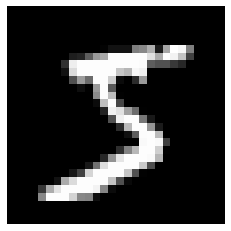

In [6]:
sample_im = x_train[0].view(28, 28)
show_image(sample_im)

We'll take one of these 3x3 kernels and run them over and down the image in a series of horizontal sweeps, at each step doing element-wise multiplication and rolling it up into one sum to capture the feature at that position. This is a convolution.

In [7]:
def convolve(im, kernel):
    height,width = im.shape
    res = torch.zeros((height, width))
    for col in range(1, height-2):
        for row in range(1, width-2):
            # elementwise mult between kernel and the scanned section of image
            scanned = im[row-1:row+2, col-1:col+2]
            pixel = (scanned * kernel).sum()
            res[row][col] = pixel
    return res

Notice how the parts of the image representing the top edge of a line are brightly activated, the bottom edges are the least activated. In this context a "top" edge, for instance, means an edge where the top part is darker (lesser pixel values) and the bottom part is lighter (greater pixel values).

torch.Size([28, 28])

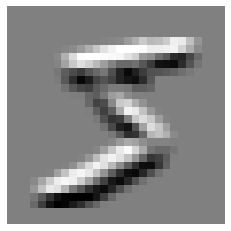

In [8]:
res = convolve(sample_im, k_top_edge)
show_image(res)
res.shape

We can do the same for side and bottom edges.

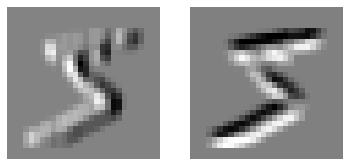

In [9]:
show_images((convolve(sample_im, k_left_edge), convolve(sample_im, k_bottom_edge)))

# Feature Channels

In fact, we could make an output with multiple channels, each channel storing a single feature.

In [10]:
def multichannel_convolution(im, kernels):
    channels = [] 
    for k in kernels:
        channels.append(convolve(im, k))
    return torch.stack(channels)

Here we've created a tensor with three output channels.

In [11]:
multichannel =multichannel_convolution(sample_im, (k_top_edge, k_bottom_edge,k_left_edge)) 
multichannel.shape

torch.Size([3, 28, 28])

Visualizing them as an RGB image highlights how they can be understood as different "features" that are part of the same image. Red is the top, green is the bottom, blue is the left.

<AxesSubplot:>

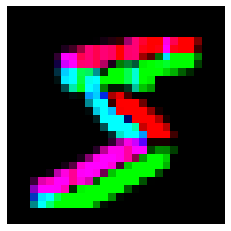

In [12]:
show_image(multichannel.clip(0,1))

# Downsampling

A very useful thing convolutional layers can also do is reduce the height and width of an image. We'll do that in the function below, with a "stride" of 2, by skipping the kernel across the input image 2 pixels at a time, and storing them into a result map that's half the height and width of the input.

In [16]:
def convolve_and_downsample(im, kernel, stride=2):
    height,width = im.shape
    res = torch.zeros((height//stride, width//stride))
    for col in range(1, height-2, stride):
        for row in range(1, width-2, stride):
            # elementwise mult between kernel and the scanned section of image
            scanned = im[row-1:row+2, col-1:col+2]
            pixel = (scanned * kernel).sum()
            res[row//stride][col//stride] = pixel
    return res

Now we should be able to both capture features and also represent them in a lower dimensionality, which is greatly useful for saving computational demands in the deeper layers of a model.

In [17]:
smaller = convolve_and_downsample(sample_im, k_top_edge, stride=2)
smaller.shape

torch.Size([14, 14])

<AxesSubplot:>

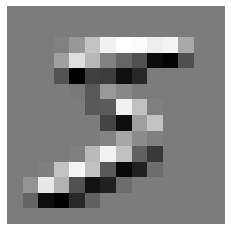

In [18]:
show_image(smaller)

# Multiple input and output channels

The convolutional layer of a neural network acts based on this process but learns, during training, what parameters to use in the kernels in order to best recognize the features it needs to recognize. It will receive a tensor with multiple channels as input, run kernels across each of them, and produce an output with multiple channels, representing multiple "features" recognized.

Each output channel of the layer will be formed using multiple kernels, one for each of the input channel. The "pixels" of one output channel will be formed by combining (by adding them, for instance), the summed results of each kernel's convolution with each of the input channels. Hence the dimensionality of a convolutional layer's parameters is (output_channels, input_channels, kernel, kernel). For RGB input with10 output channels and a 5x5 kernel, it's (3, 10, 5, 5).

This also means, in practice, that in addition to diminishing the height and width of a tensor, we can greatly increase its channel count, allowing the model to learn a great number of features down the line. We might start with a (1x28x18) image and, deep into the model's layers, find a convolutional layer producing a (256x2x2) output!

Let's break it down by calculating a single pixel for a layer with 3 input channels and 3 outputs, with a 3x3 kernel size. To make it simpler to visualize, we'll make it so that each output channel has 3 copies of the same kernel which it will apply to the input channels. We hope this way to get a 3 channel output image where red represents top edges, green bottom edges, and blue left edges.

torch.Size([3, 150, 150])

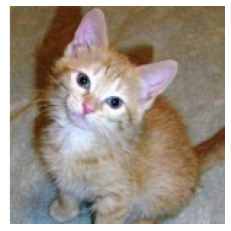

In [48]:
cat = torch.load('data/cat.pkl')
show_image(cat)
cat.shape

<AxesSubplot:>

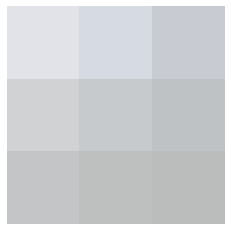

In [110]:
# section of the image to scan (randomly picked)
scanned = cat[:, 75:78, 75:78]
scanned.shape
show_image(scanned)

The "scanned" tensor will be the part inside the nested for loops we just looked at. As we convolve across the rows and columns, we're sliding the kernel over all the little 3x3 sections like this.

In [111]:
kernels = torch.stack((
    torch.stack((k_top_edge, k_top_edge, k_top_edge)),
    torch.stack((k_bottom_edge, k_bottom_edge, k_bottom_edge)),
    torch.stack((k_left_edge, k_left_edge, k_left_edge))
))

scanned.shape, kernels.shape 

(torch.Size([3, 3, 3]), torch.Size([3, 3, 3, 3]))

In [112]:
in_channels = 3
out_channels = 3

out_channels_for_pixel = []

for cout in range(out_channels):
    pixel = 0
    for cin in range(in_channels):
        kernel = kernels[cout][cin]
        elementwise = kernel * scanned[cin]
        pixel += elementwise.sum()
    out_channels_for_pixel.append(pixel)

out_channels_for_pixel

[tensor(-0.89), tensor(0.89), tensor(-0.59)]

Well, that's not very impressive to look at. Those are the three channels for a single value of output. The output layer, then, would have one pixel that looks like this:

<AxesSubplot:>

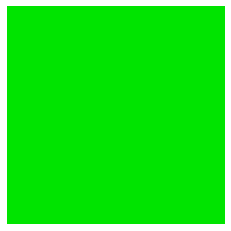

In [117]:
show_image(torch.tensor(out_channels_for_pixel).view(3,1,1).clip(0,1))

Let's try running it across the whole input image before getting into the weeds of the tensor magic in the function below. This is a kind of version of the forward pass of a convolutional layer.

In [119]:
def forward_pass(im, kernels):
    in_channels, height, width = im.shape
    out_channels = kernels.shape[0]
    
    result = torch.zeros((out_channels, height, width))
    
    for col in range(1, height-2):
        for row in range(1, width - 2):
            pixel = None
            # grab the 3x3 section of image we're going to multiply with the kernel. 
            scanned = im[:, row-1:row+2, col-1:col+2]
            # Add an extra unit dimension after channel.
            scanned = scanned[None]
            pixel = (scanned * kernels).sum(dim=(1, 2, 3))
            result[:, row, col] = pixel
    
    return result

In [120]:
result = forward_pass(cat, kernels)
result.shape

torch.Size([3, 150, 150])

See how the kernels we've defined, which look for edges, manage to show up pretty visibly in capturing the different kinds of edges in the original image:

<AxesSubplot:>

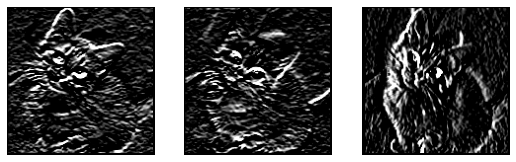

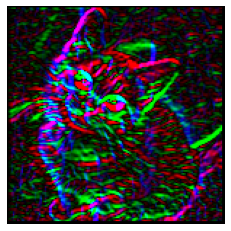

In [122]:
show_images(result.clamp(0,1))
show_image(result.clamp(0,1))

Let's now zoom in on that pixel calculation code and break it down step by step. We're going to rely on tensor broadcasting to do a bunch of repeated multiplications on our behalf, stretching out _both_ the input and kernel tensors, multiplying them together into a very large tensor, and then summing up different dimensions which correspond to the kernels we wanted to add together in the first place.

In [123]:
im=cat
row=75
col=75

scanned = im[:, row-1:row+2, col-1:col+2]
scanned.shape

torch.Size([3, 3, 3])

So far so good, it's what we expect: a little 3x3 pixel chunk with three channels

Let's briefly remember kernels' shape, which is (out_channels, in_channels, kernel_height, kernel_width)

In [124]:
kernels.shape

torch.Size([3, 3, 3, 3])

In [98]:
scanned = scanned[None]
scanned.shape

torch.Size([1, 3, 3, 3])

Now we've added another unit dimension at the very beginning, because...

In [127]:
elementwise=scanned * kernels
elementwise.shape

torch.Size([3, 3, 3, 3])

... that unit dimension gets broadcasted across the kernels "out_channels" dimesion...

In [128]:
pixel = elementwise.sum(dim=(1, 2, 3))
pixel

tensor([-1.13,  1.13, -0.44])

And now we sum along three different dimensions. The last two are quite intuitive. When we had only 1-dimensional kernels and images we would find (kernels * scanned).sum(), folding up the whole kernel's application into one sum. That's the same thing as dim=2 and dim=3 are doing above, since those dimensions correspond to height and width. Summing along the dim=1 accomplishes the fact that for each output channel, we wish to sum together the result of applying the kernels to each input channel. 1 is the input_channel dimenson, so summing along it gives us a vector of dimension out_channels, in other words, the corresponding channel values for each pixel of the layer!

# Can We Train Yet?

No.

To see why not, let's try to capture the gradients of the kernel tensor after applying the convolution's forward pass, above. We'll apply a pretend loss function to the result, call .backward() on it, and we'll have gradients to use to optimize the kernels, right?

In [132]:
def pretend_loss(tsr):
    return tsr.mean()

kernels.grad = None
kernels.requires_grad_(True)
result = forward_pass(cat, kernels)
loss = pretend_loss(result)
loss.backward()

print(f'kernel gradients = {kernels.grad}')

kernel gradients = None


The loop we're using to iterate over the layer's input and fill its output is ultimately not done in a way that let's it be automatically differentiable and therefore able to calculate gradients. To see how to implement convolutional networks in a differentiable way that allows us to make real models, then stay tuned for the upcoming demo _Convolutions Part II: Into the Matrix_.